In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 30 12:27:53 2020

@author: ifenty
"""
import os
import sys
import time
import hashlib
import json
import numpy as np
import importlib
sys.path.append('/Users/ifenty/git_repo_others/ECCOv4-py')
import ecco_v4_py as ecco

# make changes to example.py file

importlib.reload(ecco)
%load_ext autoreload
%autoreload 2

In [5]:
#sys.path.append('/Users/ifenty/git_repo_others/ECCO-ACCESS/ecco-cloud-utils')
#import ecco_cloud_utils as ea
from pathlib import Path
import pandas as pd
import netCDF4 as nc4
import xarray as xr
import datetime
from pprint import pprint
from collections import OrderedDict
import pyresample as pr
import uuid
import pickle
import matplotlib.pyplot as plt
from pandas import read_csv

In [6]:
# uses the MITgcm simplegrid package by Greg Moore and Ian Fenty
# https://github.com/nasa/simplegrid

sys.path.append('/Users/ifenty/git_repo_others/simplegrid/')
import simplegrid as sg

In [7]:
sys.path.append('/Users/ifenty/git_repo_others/ECCO-Dataset-Production/processing/src/utils/')
import gen_netcdf_utils as gen_netcdf_utils
importlib.reload(gen_netcdf_utils)

<module 'gen_netcdf_utils' from '/Users/ifenty/git_repo_others/ECCO-Dataset-Production/processing/src/utils/gen_netcdf_utils.py'>

# Load Product Generation Config Yaml

In [8]:
import yaml
with open('/Users/ifenty/git_repo_others/ECCO-v4-Configurations/ECCOv4 Release 5/metadata/product_generation_config.yaml', 'r') as file:
    product_generation_config = yaml.safe_load(file)
product_generation_config.keys()

dict_keys(['create_checksum', 'read_ecco_grid_for_native_load', 'extra_prints', 'download_all_fields', 'use_workers_to_download', 'compare_checksums', 'ecco_version', 'product_version', 'array_precision', 'model_start_time', 'model_end_time', 'num_vertical_levels', 'geospatial_vertical_min', 'latlon_grid_resolution', 'latlon_effective_grid_radius', 'latlon_grid_area_extent', 'custom_grid_and_factors', 'grid_files_dir', 'custom_factors_dir', 'source_grid_min_L', 'source_grid_max_L', 'source_grid_ftype', 'target_grid_ftype', 'ecco_grid_dir', 'ecco_grid_dir_mds', 'mapping_factors_dir', 'ecco_code_name', 'ecco_code_dir', 'ecco_access_dir', 'ecco_configurations_name', 'ecco_configurations_subfolder', 'metadata_dir', 'model_output_dir', 'local_file_dir_to_upload', 'processed_output_dir_base', 'ecco_grid_filename', 'filename_tail_1D', 'filename_tail_latlon', 'filename_tail_native', 'podaac_metadata_filename', 'processing_code_filename', 'history', 'references', 'source', 'project_summary', 'd

## Define some parameters based on the product_generation_config yaml fields

In [9]:
# Define fill values for binary and netcdf based on provided array_precision
# ECCO always uses -9999 for missing data.
if product_generation_config['array_precision'] == 'float32':
    # binary_output_dtype = '>f4'
    array_precision = np.float32
    netcdf_fill_value = nc4.default_fillvals['f4']
else:
    # binary_output_dtype = '>f8'
    array_precision = np.float64
    netcdf_fill_value = nc4.default_fillvals['f8']

# num of depth levels
nk = product_generation_config['num_vertical_levels']

ecco_start_time = np.datetime64(product_generation_config['model_start_time'])
ecco_end_time   = np.datetime64(product_generation_config['model_end_time'])
        
print(f'netcdf fill values {netcdf_fill_value}')

netcdf fill values 9.969209968386869e+36


# Load Metadata

In [10]:
metadata_json_dir = Path(product_generation_config['metadata_dir'])
metadata_files = np.sort(list(metadata_json_dir.glob('*json')))

# load each metadata json
metadata = dict()
for f in metadata_files:
    #print(f, f.stem)
    with open(f, 'r') as fp:
        metadata[f.stem] = json.load(fp)

# print all the metadata names
pprint(list(metadata.keys()))

# no idea why these are merged
variable_metadata_native = metadata['variable_metadata'] + metadata['geometry_metadata_for_native_datasets']

# merge metadata together into a single unholy beast
all_metadata = {'var_native': variable_metadata_native, 
                'var_latlon': metadata['variable_metadata_for_latlon_datasets'], 
                'coord_native': metadata['spatial_coordinate_metadata_for_native_datasets'], 
                'coord_latlon': metadata['spatial_coordinate_metadata_for_latlon_datasets'], 
                'global_all': metadata['global_metadata_for_all_datasets'], 
                'global_native': metadata['global_metadata_for_native_datasets'], 
                'global_latlon': metadata['global_metadata_for_latlon_datasets'],
                'geometry_native': metadata['geometry_metadata_for_native_datasets'],
                'geometry_latlon': metadata['geometry_metadata_for_latlon_datasets'],
                'groupings_1D': metadata['groupings_for_1D_datasets'],
                'groupings_native': metadata['groupings_for_native_datasets'],
                'groupings_latlon': metadata['groupings_for_latlon_datasets'],
                'coord_time': metadata['time_coordinate_metadata']}

global_metadata_native = metadata['global_metadata_for_all_datasets'] + metadata['global_metadata_for_native_datasets']

['dataset_summary',
 'geometry_metadata_for_latlon_datasets',
 'geometry_metadata_for_native_datasets',
 'global_metadata_for_1D_datasets',
 'global_metadata_for_all_datasets',
 'global_metadata_for_latlon_datasets',
 'global_metadata_for_native_datasets',
 'groupings_for_1D_datasets',
 'groupings_for_latlon_datasets',
 'groupings_for_native_datasets',
 'spatial_coordinate_metadata_for_latlon_datasets',
 'spatial_coordinate_metadata_for_native_datasets',
 'time_coordinate_metadata',
 'variable_metadata',
 'variable_metadata_for_1D_datasets',
 'variable_metadata_for_latlon_datasets']


In [11]:
# ========== <Metadata setup> =============================================================
# Define tail for dataset description (summary)
dataset_description_tail_1D = product_generation_config['dataset_description_tail_1D']
dataset_description_tail_native = product_generation_config['dataset_description_tail_native']
dataset_description_tail_latlon = product_generation_config['dataset_description_tail_latlon']

processed_output_dir_base = Path(product_generation_config['processed_output_dir_base'])
#product_generation_config['mapping_factors_dir'] = Path(product_generation_config['mapping_factors_dir'])

extra_prints=True

product_type='native'
# ========== <Native/Latlon setup> ========================================================
if extra_prints: print('\nproduct type', product_type)

if product_type == 'native':
    dataset_description_tail = dataset_description_tail_native
    groupings = all_metadata['groupings_native']
    output_dir_type = processed_output_dir_base / 'native'
elif product_type == 'latlon':
    dataset_description_tail = dataset_description_tail_latlon
    groupings = all_metadata['groupings_latlon']
    output_dir_type = processed_output_dir_base / 'lat-lon'


product type native


In [12]:
metadata['global_metadata_for_all_datasets'];

In [13]:
filename ='GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'

# Load ECCO Grid

In [14]:
ecco_grid_dir_mds = Path('/Users//ifenty/tmp/ECCO_V4r5_grid/grid_podaac/')

## Core tile files

In [15]:
#%%
# LOAD TILE FILES
mitgrid_files = list(ecco_grid_dir_mds.glob('tile*mitgrid'))
mitgrid_tile = dict()
mitgrid_tile[1] = sg.gridio.read_mitgridfile(ecco_grid_dir_mds / 'tile001.mitgrid', 90, 270)
mitgrid_tile[2] = sg.gridio.read_mitgridfile(ecco_grid_dir_mds / 'tile002.mitgrid', 90, 270)
mitgrid_tile[3] = sg.gridio.read_mitgridfile(ecco_grid_dir_mds / 'tile003.mitgrid', 90, 90)
mitgrid_tile[4] = sg.gridio.read_mitgridfile(ecco_grid_dir_mds / 'tile004.mitgrid', 270, 90)
mitgrid_tile[5] = sg.gridio.read_mitgridfile(ecco_grid_dir_mds / 'tile005.mitgrid', 270, 90)

XG_igjg = dict()
YG_igjg = dict()

for i in range(1,6):
    XG_igjg[i] = mitgrid_tile[i]['XG'].T
    YG_igjg[i] = mitgrid_tile[i]['YG'].T

XG_igjg_tiles = ecco.llc_ig_jg_faces_to_tiles(XG_igjg)
YG_igjg_tiles = ecco.llc_ig_jg_faces_to_tiles(YG_igjg)


llc_faces_to_tiles: data_tiles shape  (13, 91, 91)
llc_faces_to_tiles: data_tiles dtype  >f8
llc_faces_to_tiles: data_tiles shape  (13, 91, 91)
llc_faces_to_tiles: data_tiles dtype  >f8


## Construct horizontal cell bounds for tracer points

In [16]:
XC_bnds = np.zeros((13,90,90,4))
YC_bnds = np.zeros((13,90,90,4))

for tile in range(13):
    XC_bnds[tile,:,:,0] = XG_igjg_tiles[tile, :-1, :-1] # --
    XC_bnds[tile,:,:,1] = XG_igjg_tiles[tile, :-1, 1:]   # -+
    XC_bnds[tile,:,:,2] = XG_igjg_tiles[tile, 1:,  1:]   # ++
    XC_bnds[tile,:,:,3] = XG_igjg_tiles[tile, 1:, :-1] # +-

    YC_bnds[tile,:,:,0] = YG_igjg_tiles[tile, :-1, :-1] # --
    YC_bnds[tile,:,:,1] = YG_igjg_tiles[tile, :-1, 1:]   # -+
    YC_bnds[tile,:,:,2] = YG_igjg_tiles[tile, 1:,  1:]   # ++
    YC_bnds[tile,:,:,3] = YG_igjg_tiles[tile, 1:, :-1] # +-

#%%
tile_coords = list(range(13))
ij_coords = list(range(90))
nbh_coords = list(range(4))

XC_bnds_DA = xr.DataArray(XC_bnds, dims=["tile","j","i","nbh"],\
                          coords=[tile_coords, ij_coords, ij_coords, nbh_coords])
YC_bnds_DA = xr.DataArray(YC_bnds, dims=["tile","j","i","nbh"],\
                          coords=[tile_coords, ij_coords, ij_coords, nbh_coords])
XC_bnds_DA.name = 'XC_bnds'
YC_bnds_DA.name = 'YC_bnds'

## Construct vertical cell bounds for tracer points

In [17]:
# Make depth bounds (top and bottom of cell)
depth_bounds = np.zeros((nk,2))

# load drF from model grid directory
tmp = ecco.load_binary_array(ecco_grid_dir_mds, 'DRF.data', ni=1,nj=1,nk=-1,skip=0,
                      filetype = '>f', less_output = False)
drF = [x[0][0] for x in tmp]
cell_bottom_depths = np.cumsum(drF)

for k in range(nk):
    if k == 0:
        # k=0, the top of the grid cell is at 0m depth
        depth_bounds[k,0] = 0.0
    else:
        # below k = 0, the top is the same as the bottom of the cell above
        depth_bounds[k,0] = -cell_bottom_depths[k-1]
    
    depth_bounds[k,1] = -cell_bottom_depths[k]
    
k_coords = list(range(50))
nbv_coords = list(range(2))
                
Z_bnds_DA = xr.DataArray(data=depth_bounds, dims=['k','nbv'], \
    coords=[k_coords, nbv_coords])
Z_bnds_DA.name = 'Z_bnds'
print('\nfirst 5 levels of Z_bnds')
pprint(Z_bnds_DA[:5,:].values)

print('\nlast 5 levels of Z_bnds')
pprint(Z_bnds_DA[-5:,:].values)

load_binary_array: loading file /Users/ifenty/tmp/ECCO_V4r5_grid/grid_podaac/DRF.data
load_binary_array: loading all 2D records.  nk = 50
load_binary_array: data array shape  (50, 1, 1)
load_binary_array: data array type  >f4

first 5 levels of Z_bnds
array([[  0., -10.],
       [-10., -20.],
       [-20., -30.],
       [-30., -40.],
       [-40., -50.]])

last 5 levels of Z_bnds
array([[-4082. , -4446.5],
       [-4446.5, -4834. ],
       [-4834. , -5244.5],
       [-5244.5, -5678. ],
       [-5678. , -6134.5]])


## Make Horizontal and Vertical Cell bounds DataArrays

In [18]:
# 2D
XC_YC_bnds = xr.merge([XC_bnds_DA, YC_bnds_DA])

# 3D
XC_YC_Z_bnds = xr.merge([XC_bnds_DA, YC_bnds_DA, Z_bnds_DA])

print(XC_YC_bnds)
print('\n')
print(XC_YC_Z_bnds)

<xarray.Dataset>
Dimensions:  (tile: 13, j: 90, i: 90, nbh: 4)
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * nbh      (nbh) int64 0 1 2 3
Data variables:
    XC_bnds  (tile, j, i, nbh) float64 -115.0 -115.0 -107.9 ... -115.0 -108.5
    YC_bnds  (tile, j, i, nbh) float64 -88.18 -88.32 -88.3 ... -88.18 -88.16


<xarray.Dataset>
Dimensions:  (tile: 13, j: 90, i: 90, nbh: 4, k: 50, nbv: 2)
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * nbh      (nbh) int64 0 1 2 3
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * nbv      (nbv) int64 0 1
Data variables:
    XC_bnds  (tile, j, i, nbh) float64 

## Load the standard grid fields

In [19]:
# load ecco grid
print(ecco_grid_dir_mds)
ecco_grid =  ecco.load_ecco_vars_from_mds(str(ecco_grid_dir_mds),
                                    str(ecco_grid_dir_mds),
                                    '',
                                    vars_to_load = 'all',
                                    drop_unused_coords = False,
                                    grid_vars_to_coords = False,
                                    coordinate_metadata = metadata['spatial_coordinate_metadata_for_native_datasets'],
                                    variable_metadata = metadata['geometry_metadata_for_native_datasets'],
                                    global_metadata = global_metadata_native,
                                    cell_bounds = XC_YC_Z_bnds,
                                    less_output=True).load();

print('\nAfter Load')
print(ecco_grid.coords)
print(ecco_grid.data_vars)

/Users/ifenty/tmp/ECCO_V4r5_grid/grid_podaac


/srv/conda/envs/notebook/lib/python3.10/site-packages/xmitgcm/mds_store.py:913: UserWarning: Couldn't find available_diagnostics.log in /Users/ifenty/tmp/ECCO_V4r5_grid/grid_podaac or /Users/ifenty/tmp/ECCO_V4r5_grid/grid_podaac. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "


<xarray.Dataset>
Dimensions:  (tile: 13, j: 90, i: 90, nbh: 4, k: 50, nbv: 2)
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * nbh      (nbh) int64 0 1 2 3
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * nbv      (nbv) int64 0 1
Data variables:
    XC_bnds  (tile, j, i, nbh) float64 -115.0 -115.0 -107.9 ... -115.0 -108.5
    YC_bnds  (tile, j, i, nbh) float64 -88.18 -88.32 -88.3 ... -88.18 -88.16
    Z_bnds   (k, nbv) float64 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03

After Load
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 

In [20]:
ecco_grid_orig = ecco_grid.copy(deep=True)

In [21]:
grid_files = np.sort(list(ecco_grid_dir_mds.glob('*')));
for gf in grid_files:
        pprint(gf.name)

'.DS_Store'
'AngleCS.data'
'AngleCS.meta'
'AngleSN.data'
'AngleSN.meta'
'BATHY_ICE_SHELF_CAVITY_PLUS_ICE_FRONT_LLC_0090.bin'
'DRC.data'
'DRC.meta'
'DRF.data'
'DRF.meta'
'DXC.data'
'DXC.meta'
'DXF.data'
'DXF.meta'
'DXG.data'
'DXG.meta'
'DXV.data'
'DXV.meta'
'DYC.data'
'DYC.meta'
'DYF.data'
'DYF.meta'
'DYG.data'
'DYG.meta'
'DYU.data'
'DYU.meta'
'Depth.data'
'Depth.meta'
'GRID_README.txt'
'ICE_DRAFT_ICE_SHELF_CAVITY_PLUS_ICE_FRONT_LLC_0090.bin'
'K_icefront.data'
'K_icefront.meta'
'PHrefC.data'
'PHrefC.meta'
'PHrefF.data'
'PHrefF.meta'
'RAC.data'
'RAC.meta'
'RAC_frac.data'
'RAS.data'
'RAS.meta'
'RAW.data'
'RAW.meta'
'RAZ.data'
'RAZ.meta'
'RC.data'
'RC.meta'
'RF.data'
'RF.meta'
'R_icefront.data'
'R_icefront.meta'
'XC.data'
'XC.meta'
'XG.data'
'XG.meta'
'YC.data'
'YC.meta'
'YG.data'
'YG.meta'
'hFacC.data'
'hFacC.meta'
'hFacS.data'
'hFacS.meta'
'hFacW.data'
'hFacW.meta'
'mask2dICF.data'
'mask2dICF.meta'
'mask2dSHI.data'
'mask2dSHI.meta'
'mask2dSHIICF.data'
'mask2dSHIICF.meta'
'mask3dICF.data'

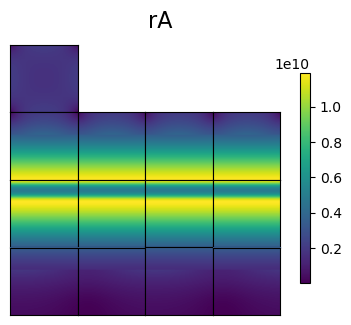

In [23]:
# Read and plot grid cell area
ecco.plot_tiles(ecco_grid.rA,rotate_to_latlon=True,layout='latlon',show_tile_labels=False, title='rA',fig_size=4, show_colorbar=True, interpolation=None);

# Load non-standard ice shelf/ice front parameters

In [24]:
# Read and plot ice draft and bathy
# ice draft given to the modle
ice_draft_bin = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'ICE_DRAFT_ICE_SHELF_CAVITY_PLUS_ICE_FRONT_LLC_0090.bin', less_output=True)

# bathy given to the model
bathy_bin = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'BATHY_ICE_SHELF_CAVITY_PLUS_ICE_FRONT_LLC_0090.bin', less_output=True)

In [25]:
R_icefront = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'R_icefront.data', less_output=True)
K_icefront = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'K_icefront.data', less_output=True)

In [26]:
# 2D ice masks
mask2dSHI = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'mask2dSHI.data', less_output=True)
mask2dICF = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'mask2dICF.data', less_output=True)
mask2dSHIICF = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'mask2dSHIICF.data', less_output=True)

# 3D ice masks
mask3dSHI = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'mask3dSHI.data',nk=50,  less_output=True)
mask3dICF = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'mask3dICF.data',nk=50,  less_output=True)
mask3dSHIICF = ecco.read_llc_to_tiles(ecco_grid_dir_mds, 'mask3dSHIICF.data', nk=50, less_output=True)
print(mask3dSHIICF.shape)

(50, 13, 90, 90)


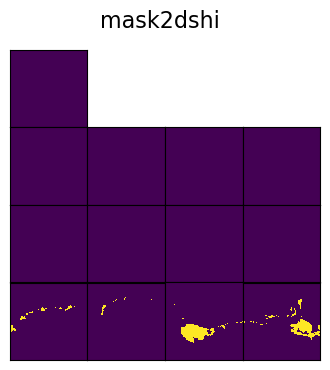

<Figure size 640x480 with 0 Axes>

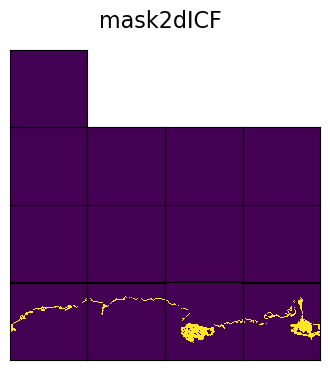

<Figure size 640x480 with 0 Axes>

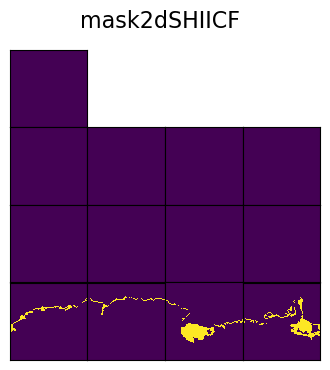

In [27]:
# plot some of these fields
ecco.plot_tiles(mask2dSHI,rotate_to_latlon=True,layout='latlon',show_tile_labels=False, title='mask2dshi',fig_size=4);

plt.figure();
ecco.plot_tiles(mask2dICF,rotate_to_latlon=True,layout='latlon',show_tile_labels=False, title='mask2dICF',fig_size=4);

plt.figure();
ecco.plot_tiles(mask2dSHIICF,rotate_to_latlon=True,layout='latlon',show_tile_labels=False, title='mask2dSHIICF',fig_size=4);

# Construct seafloor depth, ocean column thickness, and ice shelf draft

These fields can be different than what are provided to the model as input because of limits to hFacC

In [28]:
#ecco.plot_tiles(ecco_grid.Depth,show_colorbar=True,rotate_to_latlon=True,layout='latlon', show_tile_labels=False, cmin=0, cmax=1000);

# the model field called 'Depth' is normally interpreted as seafloor depth, but it is *actally* thickness of wet ocean column
# turns out, that is seafloor depth when the sea surface is at z=0.  Under ice shelves, the sea surface at the base
# of the ice shelf.
ocean_column_thickness = ecco_grid_orig.Depth.copy(deep=True);
ocean_column_thickness.name = 'ocean_column_thickness'
ocean_column_thickness.attrs.clear()

#  make an empty field for ice shelf draft
ice_shelf_draft = ecco_grid_orig.Depth.copy(deep=True);
ice_shelf_draft.attrs.clear()
ice_shelf_draft.name = 'ice_shelf_draft'
ice_shelf_draft.values *= 0

#ice_shelf_draft.values[:] = ice_draft_bin[:];

#ecco_grid.Depth.values[:] = bathy_bin[:]

#ecco_grid = xr.merge([ecco_grid, ocean_column_thickness, ice_shelf_draft]);
#.Depth.values = -bathy;

#ecco.plot_tiles(ecco_grid.Depth,show_colorbar=True,rotate_to_latlon=True,
#                layout='latlon', show_tile_labels=False,cmin=-2000,cmap='jet');
#ecco.plot_tiles(ecco_grid.ocean_column_thickness,show_colorbar=True,rotate_to_latlon=True,
#                    layout='latlon', show_tile_labels=False,cmax=1000, cmap='jet');
#ecco.plot_tiles(ecco_grid.ice_shelf_draft,show_colorbar=True,rotate_to_latlon=True,
#                    layout='latlon', show_tile_labels=False, cmap='jet');

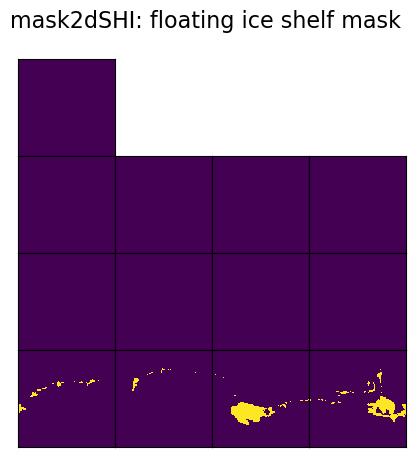

In [29]:
# the field mask2dSHI contains the mask where we have some floating ice shelf
# equal to those points with nonzero column thickness and surface hFacC equal to 0.
ecco.plot_tiles(mask2dSHI,rotate_to_latlon=True,layout='latlon',show_tile_labels=False, title='mask2dSHI: floating ice shelf mask', fig_size=5);


In [30]:
import matplotlib as mpl
#cmap = mpl.colors.ListedColormap(['w', 'r', 'b',])
#norm = mpl.colors.BoundaryNorm([0,1,2,3], cmap.N)

bathy is negative
ice draft bin is negative


/tmp/ipykernel_3721/3196195781.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 3)


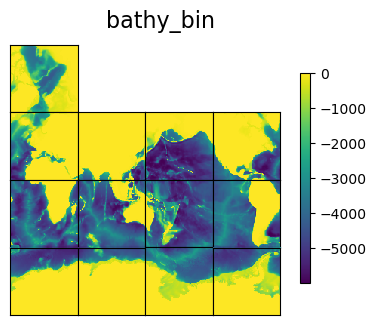

<Figure size 640x480 with 0 Axes>

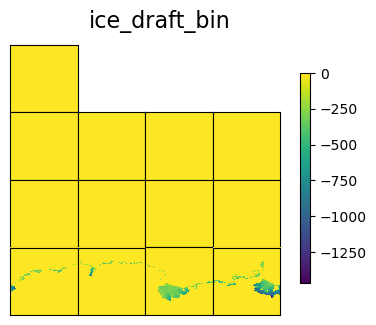

<Figure size 640x480 with 0 Axes>

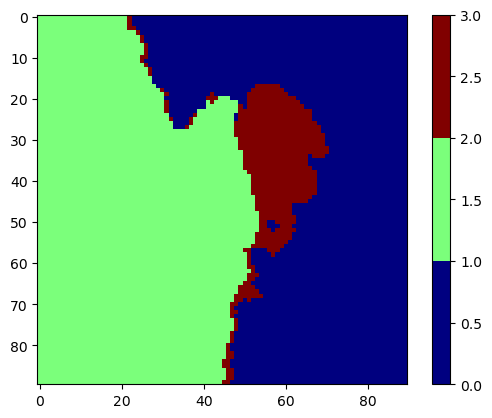

In [32]:
ecco.plot_tiles(bathy_bin,rotate_to_latlon=True,layout='latlon',show_tile_labels=False,show_colorbar=True,title='bathy_bin', fig_size=4);
plt.figure();
print("bathy is negative")
ecco.plot_tiles(ice_draft_bin,rotate_to_latlon=True,layout='latlon',show_tile_labels=False,show_colorbar=True,title='ice_draft_bin', fig_size=4);
plt.figure();
print("ice draft bin is negative")

# these ice cells have grounded ice that faces a wet cell: nonzero ice draft and no floating ice
grounded_ice_mask = np.where(np.logical_and(ice_draft_bin < 0, mask2dSHI ==0),1,0)

tmp_mask = grounded_ice_mask *0;
tmp_mask = np.where(mask2dSHI == 1, 5, tmp_mask)
tmp_mask = np.where(ecco_grid.maskC[0] == 1, 1, tmp_mask)
tmp_mask = np.where(grounded_ice_mask == 1, 3, tmp_mask)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = cm.get_cmap('jet', 3)

plt.figure();
plt.imshow(tmp_mask[9],cmap=cmap, vmin=0,vmax=3);plt.colorbar()

/tmp/ipykernel_3721/1458310901.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet',4)


/tmp/ipykernel_3721/1458310901.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  r[-1].ax.set_yticklabels(['', 'land or grounded ice', '', 'open ocean','', 'grounded ice', '',                        'floating ice shelf'])  # vertically oriented colorbarplt.colorbar()


[Text(1, 0.0, ''),
 Text(1, 0.5, 'land or grounded ice'),
 Text(1, 1.0, ''),
 Text(1, 1.5, 'open ocean'),
 Text(1, 2.0, ''),
 Text(1, 2.5, 'grounded ice'),
 Text(1, 3.0, ''),
 Text(1, 3.5, 'floating ice shelf'),
 Text(1, 4.0, '')]

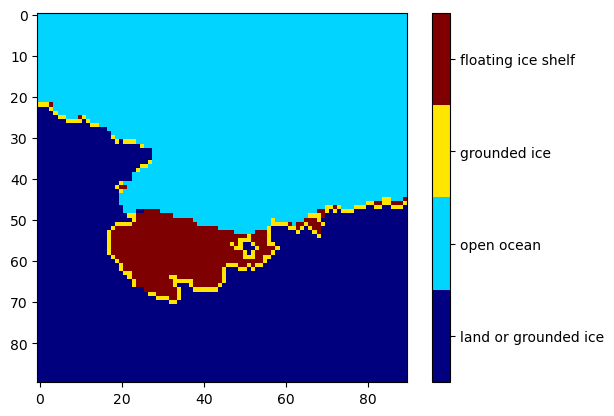

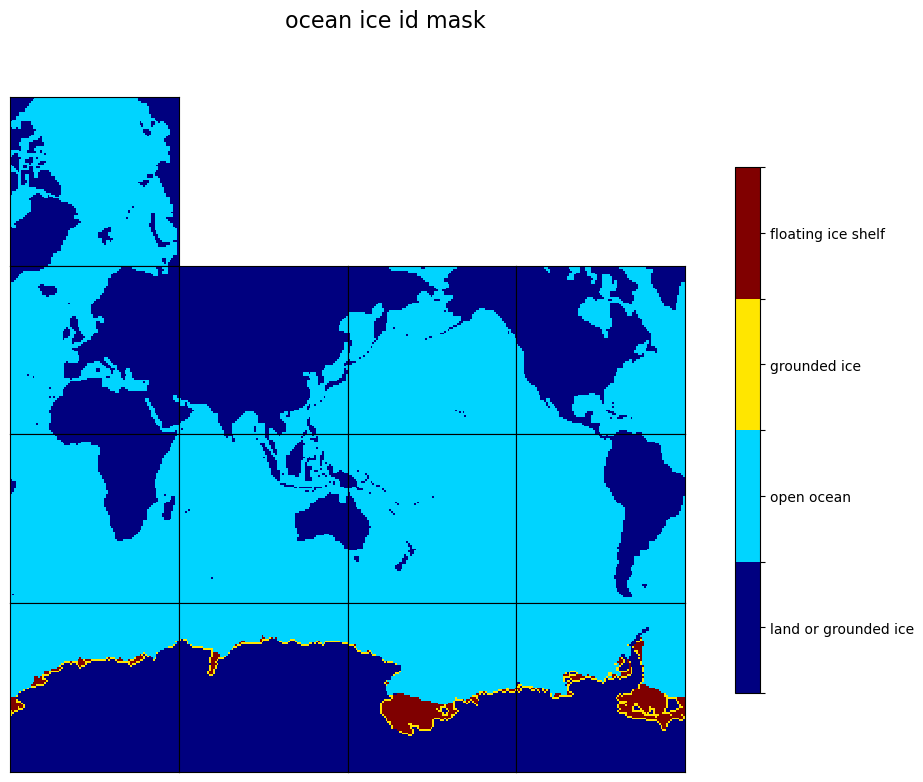

In [42]:
tmp = np.where(ecco_grid.maskC[0] == 1, 1, 0);

fig, ax = plt.subplots()

#cax = ax.imshow(data, cmap=cm.coolwarm)
tmp2 = tmp*1 + mask2dSHI*3+grounded_ice_mask*2
#tmp2 = np.where(tmp2==0,np.nan,tmp2)
cmap=cm.get_cmap('jet',4)
cax = ax.imshow(tmp2[9].T, cmap=cmap,vmin=0,vmax=4);

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[0.5,1.5,2.5,3.5])
cbar.ax.set_yticklabels(['land or grounded ice', 'open ocean','grounded ice', 'floating ice shelf'])  # vertically oriented colorbarplt.colorbar()

ocean_ice_id_mask = tmp2
r = ecco.plot_tiles(ocean_ice_id_mask,rotate_to_latlon=True,layout='latlon',show_tile_labels=False, fig_size=10,cmin=0,cmax=4, cmap=cmap,title='ocean ice id mask', show_colorbar=True);

print(r[-1])
#r[-1].set_t = r[0].colorbar(ca, ticks=[0.5,1.5,2.5,3.5])
r[-1].ax.set_yticklabels(['', 'land or grounded ice', '', 'open ocean','', 'grounded ice', '',                        'floating ice shelf'])  # vertically oriented colorbarplt.colorbar()


# Make the model seafloor depth field

we used to get model seafloor depth from the mitgcm model output field *Depth.data*,
but *Depth.data* is ocean column thickness which is not the same as seafloor depth where there is an ice-shelf cavity

The recipe for maaking model seafloor depth is as follows
* first get the 3D model field hfacc, the open water fraction of each grid cell
* next, identify all the tile,j,i points where there is a floating ice shelf
* once we've found points with a floating ice shelf, we examine the 1D hfacc array at each of those points
* the 1D hfacc array will have a surface (k=0) value of 0, and one or more nonzero (>0) values somewhere at depth
* the nonzero values below the surface show us where the ice-shelf cavity (they are the wet fractions of grid cell thickness)
* we then identify which cell has the deepest nonzero value (call it k=kb)
* the seafloor is the k=kb grid cell because it is at the bottom of the cavity, 
* then make a copy of this 1D hfacc array at that point, hfacc_modded
* set to 1 the values of hfacc_modded from k=0 to k=kb-1 (all points *above* kb) 
* the seafloor depth is found by muliply hfacc_modded with drf and then summing


In [44]:
floating_ice_shelf_pts = np.where(mask2dSHI)
floating_ice_shelf_pts_tile = floating_ice_shelf_pts[0]
floating_ice_shelf_pts_j = floating_ice_shelf_pts[1]
floating_ice_shelf_pts_i = floating_ice_shelf_pts[2]

In [63]:
seafloor_depth = ecco_grid.Depth.copy(deep=True)*-1
ice_shelf_depth = ecco_grid.Depth.copy(deep=True)*0
seafloor_depth.name = 'model ice-shelf depth'
ice_shelf_depth.name = 'model seafloor depth depth'
ocean_cavity_thickness_B = seafloor_depth *0

for p in range(len(floating_ice_shelf_pts_tile)):
#    print(f'P={p}')
    tile = floating_ice_shelf_pts_tile[p]
    j = floating_ice_shelf_pts_j[p]
    i = floating_ice_shelf_pts_i[p]


    debug = False
        
    hfacc_here = ecco_grid_orig.hFacC[:, tile,j,i].copy(deep=True)
    tmp_sum = hfacc_here*ecco_grid_orig.drF

    ocean_cavity_thickness_B[tile,j,i] = -tmp_sum.sum()

    if tile ==9 and j==25:
        debug = True;
        print(tile,j,i)
        
    if debug:
        print(f'orig hfacc here \n{hfacc_here.values}')

    # find the first and last nonzero value
    first_nonzero_k = np.where (hfacc_here > 0)[0][0]
    last_nonzero_k = np.where (hfacc_here > 0)[0][-1]
    
    if debug:
        print(f'\nfirst_nonzo_k {first_nonzero_k} \nlast_nonzero_k {last_nonzero_k}\nhfacc there {hfacc_here[last_nonzero_k].values}')

    hfacc_here_mod = hfacc_here + 0
    hfacc_here_mod[0:last_nonzero_k]=1

    if debug:
        print(f'\nmodded hfacc here \n{hfacc_here_mod.values}')

    tmp = hfacc_here_mod*ecco_grid_orig.drF
    tmp_sum = tmp.sum()
    if debug:
        print(f'\nnew seafloor depth = sum of drf*mhfac_here_mod = {tmp_sum.values}\n ')    

    seafloor_depth[tile,j,i] = -tmp_sum
    
#    now we'll look at the floating ice part
    hfacc_here_mod2 = hfacc_here + 0
    hfacc_here_mod2[first_nonzero_k+1:] = np.nan
    hfacc_here_mod2 = 1-hfacc_here_mod2
    tmp = hfacc_here_mod2*ecco_grid_orig.drF
    tmp_sum = tmp.sum()
    
    if debug:
        print(f'\nmodded hfacc2 here \n{hfacc_here_mod2.values}')

    ice_shelf_depth[tile,j,i] = tmp_sum;
    if debug:
        print(f'\nnew ice shelf depth = sum of drf*modded hfacc2 = {tmp_sum.values}')    
        print(f'orig ice shelf depth = {-ice_draft_bin[tile,j,i]}')
        print('\n')

9 25 49
orig hfacc here 
[0.        0.        0.        0.        0.        0.        0.
 0.8701852 1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        0.2       0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ]

first_nonzo_k 7 
last_nonzero_k 26
hfacc there 0.20000000298023224

modded hfacc here 
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]

new seafloor depth = sum of drf*mhfac_here_mod = 786.281982421875
 

modded hfacc2 here 
[1.        1.        1.        1.        1.        1.        1.
 0.1298148       nan       nan       nan       nan       nan       nan


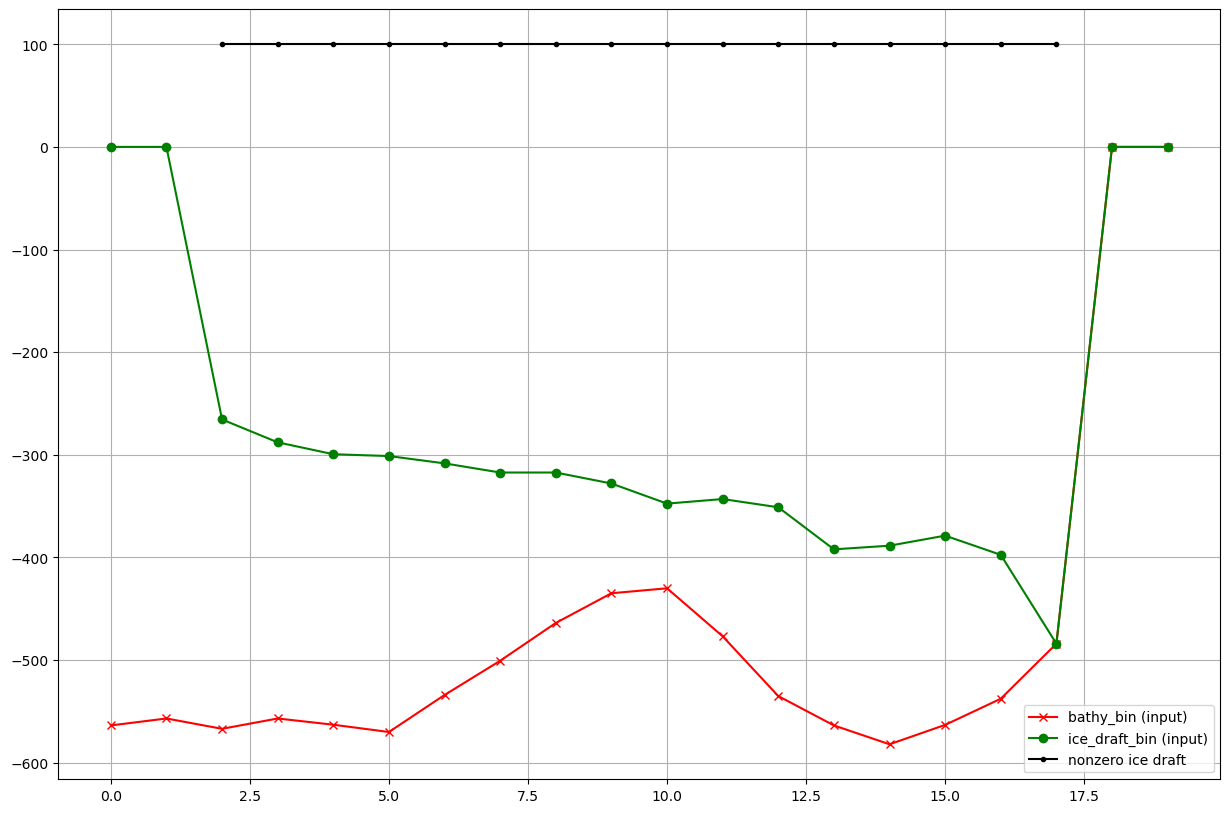

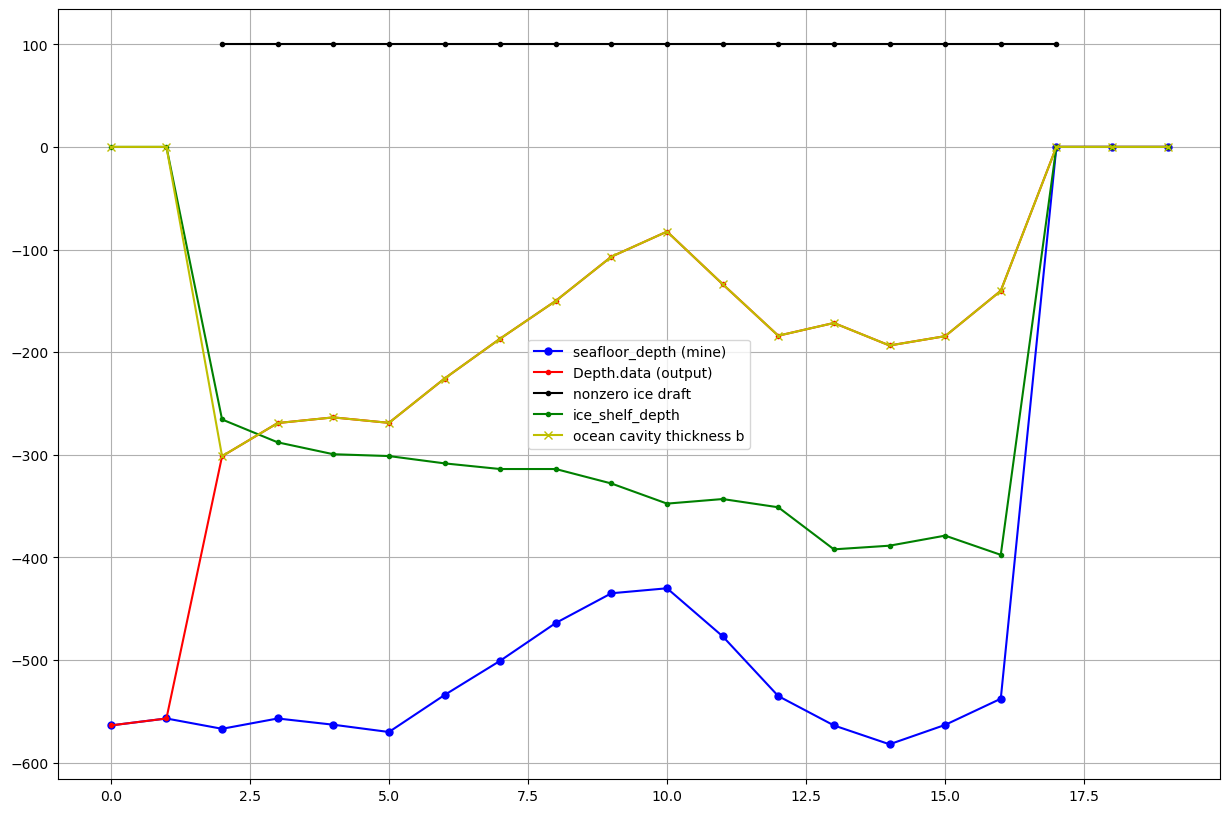

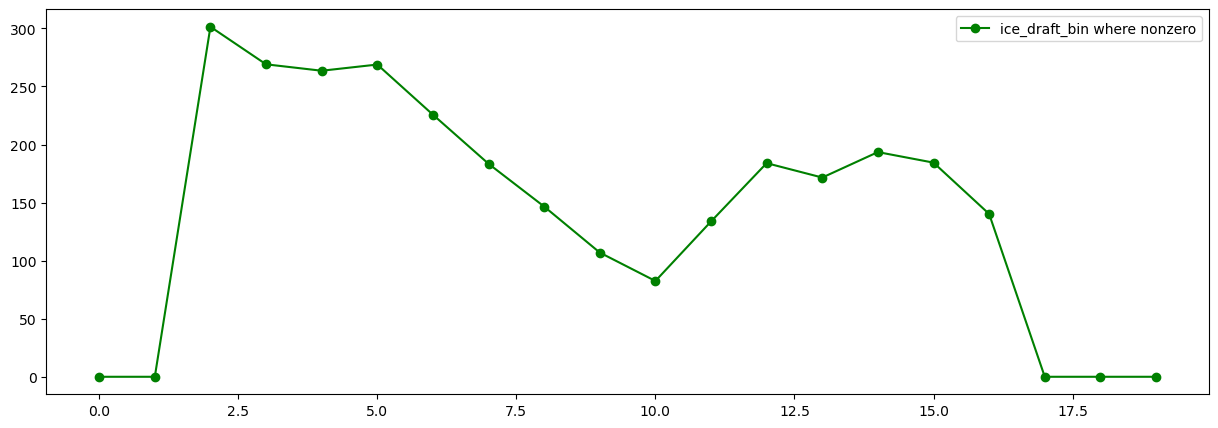

In [69]:
#ecco.plot_tiles(-ecco_grid.Depth,show_colorbar=True, cmin=-1000);
#plt.plot(-ecco_grid_orig.Depth[9,40,40:80],'r-')

c1=50
c2=70

r = 40
tmp_d = np.where(ice_draft_bin != 0, 100, np.nan)

plt.figure(figsize=[15,10])
legends=[]

plt.plot(bathy_bin[9,r,c1:c2],'rx-');legends.append('bathy_bin (input)')
plt.plot(ice_draft_bin[9,r,c1:c2],'go-');legends.append('ice_draft_bin (input)')
plt.plot(tmp_d[9,r,c1:c2],'k.-');legends.append('nonzero ice draft')
plt.grid()

plt.legend(legends)

plt.figure(figsize=[15,10])
legends=[]
plt.plot(seafloor_depth[9,r,c1:c2],'bo-',markersize=5);legends.append('seafloor_depth (mine)')
plt.plot(-ecco_grid.Depth[9,r,c1:c2],'r.-');legends.append('Depth.data (output)')

#plt.plot(-ice_shelf_cavity_thickness[9,r,:80],'yo');legends.append('ice_shelf_cavity_thickness (mine)')
plt.plot(tmp_d[9,r,c1:c2],'k.-');legends.append('nonzero ice draft')
plt.plot(-ice_shelf_depth[9,r,c1:c2],'g.-');legends.append('ice_shelf_depth')
plt.plot(ocean_cavity_thickness_B[9,r,c1:c2],'yx-');legends.append('ocean cavity thickness b')
#plt.plot(mask2dSHI[9,r,:80:]*50,'kx-');legends.append('mask2dSHI')

#plt.plot(np.where(K_icefront[9,r,:80]>0,100,np.nan),'ko');legends.append('K_icefront')
plt.legend(legends)
plt.grid()
#plt.legend(['bathy','ice_draft'])
#plt.legend(legends)

plt.figure(figsize=[15,5])
legends=[]
tmp = ice_draft_bin - bathy_bin
tmp = np.where(ice_draft_bin != 0, tmp, 0)
plt.plot((tmp)[9,r,c1:c2],'go-');legends.append('ice_draft_bin where nonzero')
plt.legend(legends)

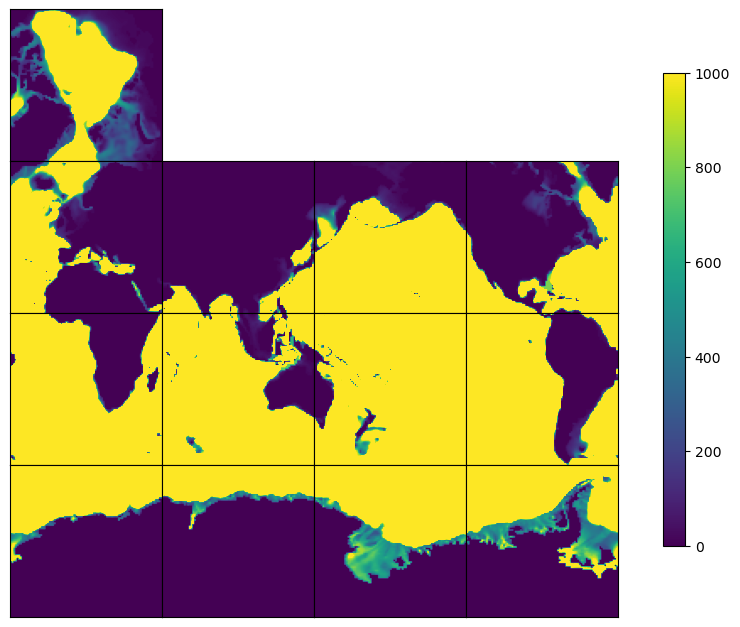

<Figure size 640x480 with 0 Axes>

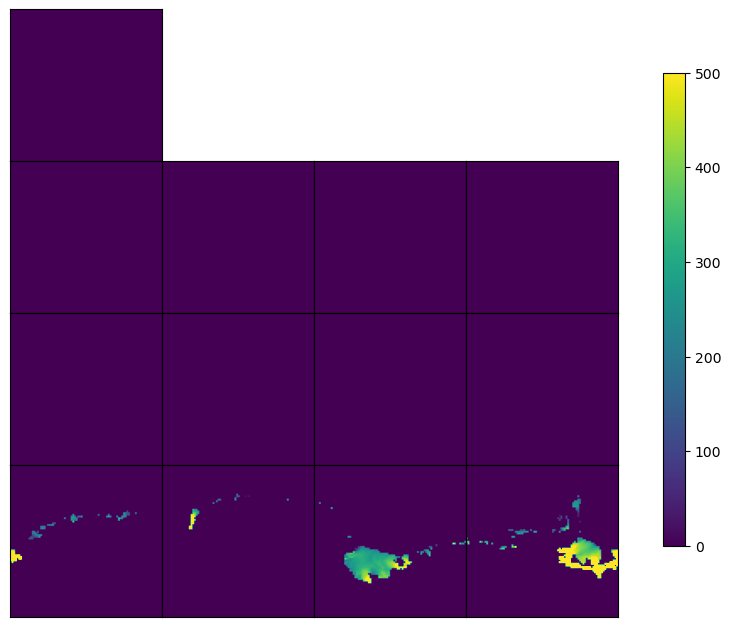

In [251]:
ecco.plot_tiles(seafloor_depth,cmax=1000,rotate_to_latlon=True,
                layout='latlon',show_tile_labels=False,show_colorbar=True);
plt.figure()
ice_shelf_cavity_thickness = seafloor_depth-ecco_grid.Depth
ecco.plot_tiles(ice_shelf_cavity_thickness,rotate_to_latlon=True,cmax=500,
                layout='latlon',show_tile_labels=False, show_colorbar=True);

(<Figure size 900x789 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

<Figure size 500x500 with 0 Axes>

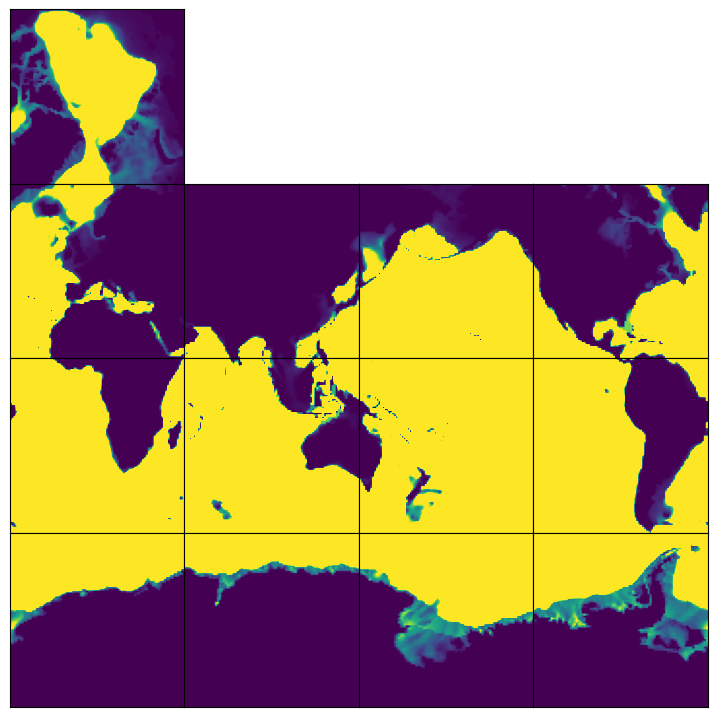

<Figure size 500x500 with 0 Axes>

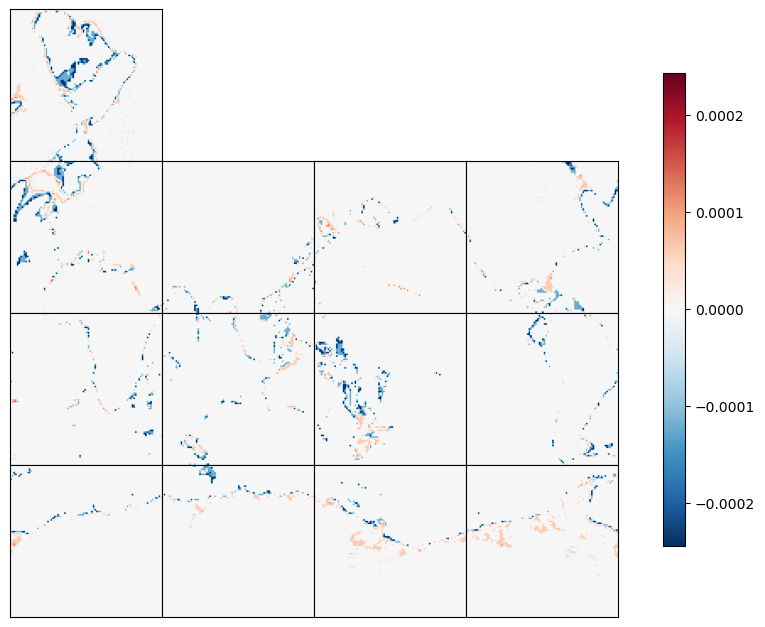

In [252]:
ocean_column_thickness = (ecco_grid_orig.hFacC * ecco_grid_orig.drF).sum(dim='k')
plt.figure(figsize=[5,5])
ecco.plot_tiles(ocean_column_thickness,cmax=1000,rotate_to_latlon=True,layout='latlon',show_tile_labels=False);

plt.figure(figsize=[5,5])
ecco.plot_tiles(ocean_column_thickness-ecco_grid_orig.Depth,rotate_to_latlon=True,layout='latlon',
                show_tile_labels=False, show_colorbar=True)

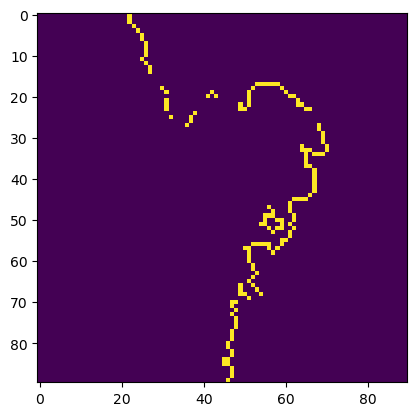

In [254]:
tmp = np.where(ice_draft_bin == bathy_bin,1,0)
tmp = np.where(bathy_bin != 0, tmp, 0)
plt.imshow(tmp[9,])

In [218]:
grouping = dict()
grouping['product'] = 'native'
grouping['name'] = 'GRID_GEOMETRY'
grouping['dataset_description'] = 'This dataset provides geometric parameters for the lat-lon-cap 90 (llc90) native model grid from the ECCO Version 4 Release 5 (V4r5) ocean and sea-ice state estimate. Parameters include grid cell face areas and side lengths; horizontal and vertical coordinates of grid cell centers and corners; horizontal grid rotation angles; and domain geometry including bathymetry and land/ocean masks.'
grouping['dimension'] = '3D'
grouping['filename'] = 'GRID_GEOMETRY'

In [219]:
#   if 3D assign depth bounds, use k as index
G = ecco_grid;
if grouping['dimension'] == '3D' and 'Z' in list(G.coords):
    G = G.assign_coords({"Z_bnds": (("k","nv"), depth_bounds)})

# apply metadata

In [220]:
reload(gen_netcdf_utils)

output_dir = Path('/Users/ifenty/tmp/20230502')

status, G, netcdf_filename, encoding =\
    gen_netcdf_utils.set_metadata(ecco, G, all_metadata, 
                                  "NA", netcdf_fill_value,
                                  grouping, output_dir, 
                                  grouping['dataset_description'], 
                                  product_generation_config, 
                                  extra_prints=True)

# add metadata for the grid data variables
G, GCMD = ecco.add_variable_metadata(all_metadata['geometry_native'], G)

# check the metadata is correct
print(output_dir, netcdf_filename)
pprint(G.Depth.attrs)
print('\n')
pprint(G.ocean_column_thickness.attrs)
print('\n')
pprint(G.ice_shelf_draft.attrs)
print('\n')
pprint(G.CS.attrs)

_ECCO_V4r5_native_llc0090.nc

... adding metadata specific to the variable

... adding coordinate metadata for native dataset

... adding global metadata for all datasets

... adding global metadata for native dataset

... creating variable encodings

... creating coordinate encodings

... merging GCMD keywords

... adding uuid

... setting time coverage resolution

... creating filename
filename: GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc

... creating output_dir /Users/ifenty/tmp/20230502/GRID_GEOMETRY

... getting PODAAC metadata
GRID_GEOMETRY _ECCO_V4r5_native_llc0090.nc
split filename into  GRID_GEOMETRY _ECCO_V4r5_native_llc0090.nc
further split tail into  native_llc0090.nc

... podaac metadata:
{'id': '10.5067/ECL5A-GRD45', 'metadata_link': 'https://cmr.earthdata.nasa.gov/search/collections.umm_json?ShortName=ECCO_L4_GEOMETRY_LLC0090GRID_V4R5', 'title': 'ECCO Geometry Parameters - llc90 Grid (Version 4 Release 5)'}

... applying PODAAC metadata

... sorting global attributes
/Use

In [226]:
print('\n... saving to netcdf ', netcdf_filename)
G.load()
G.to_netcdf(netcdf_filename, 
            encoding=encoding)
orig_uuid = G.attrs['uuid']
G.close()


... saving to netcdf  /Users/ifenty/tmp/20230502/GRID_GEOMETRY/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc


In [227]:
netcdf_filename.name

'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'

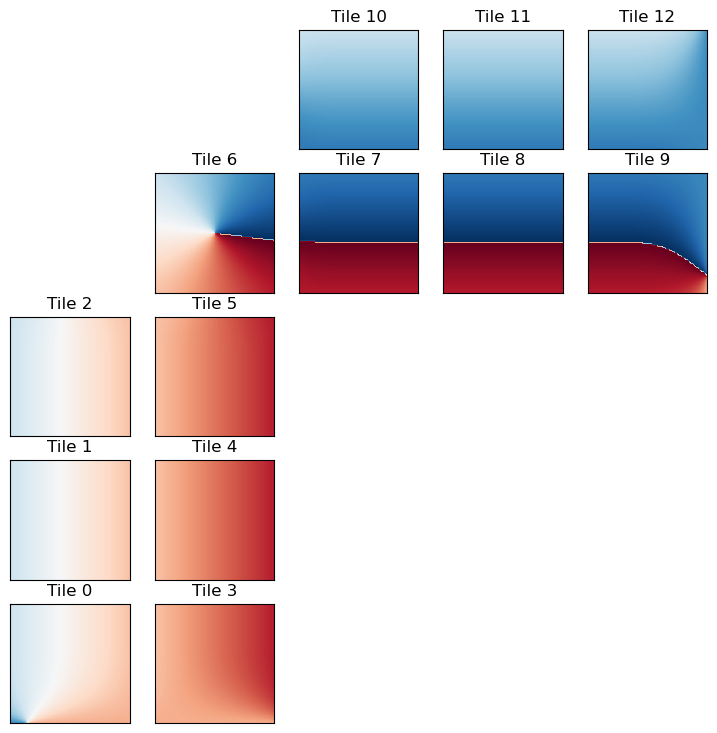

In [228]:
ecco.plot_tiles(ecco_grid_orig.XC);

In [229]:
np.sum(np.isnan(G.Depth.values!=0))

0

In [230]:

BUF_SIZE = 65536  # lets read stuff in 64kb chunks!

sha512 = hashlib.sha512()

with open(netcdf_filename, 'rb') as f:
    while True:
        data = f.read(BUF_SIZE)
        if not data:
            break
        sha512.update(data)

sha512_string = sha512.hexdigest() + '  ' + netcdf_filename.name + '\n'
print(sha512_string)

sha_filename = Path(str(netcdf_filename) + '.sha512')
print(sha_filename)

try:
    f = open(sha_filename, "w")
    try:
        f.write(sha512_string)
    finally:
        f.close()
except IOError:
    print ('could not write sha_fname')

fedc1ed1677101d7d278da1d345b8af108f8f3692d8be0ffc7a75594cc3746e69b0a1f5d61e044f411f5d3320a64a5024fd9c3e54da492561489b88f7df547ac  GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc

/Users/ifenty/tmp/20230502/GRID_GEOMETRY/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc.sha512


In [235]:
for dv in G.data_vars:
    pprint(dv);
    pprint(G[dv].attrs)
    print('\n')

'CS'
{'comment': 'CS and SN are used to calculate the geographic (meridional, '
            "zonal) components of vector fields defined on the model's llc "
            'curvilinear grid. Note: for vector field R with x and y '
            'components R_x and R_y, respectively: R_{east} = CS R_x - SN '
            'R_y.  R_{north} = SN R_x + CS R_y',
 'coordinate': 'YC XC',
 'coverage_content_type': 'modelResult',
 'long_name': 'cosine of tracer grid cell orientation vs geographical north',
 'units': '1'}


'SN'
{'comment': 'CS and SN are used to calculate the geographic (meridional, '
            "zonal) components of vector fields defined on the model's llc "
            'curvilinear grid. Note: for vector R with x and y components R_x '
            'and R_y, respectively: R_{east} = CS R_x - SN R_y. R_{north} = SN '
            'R_x + CS R_y.',
 'coordinate': 'YC XC',
 'coverage_content_type': 'modelResult',
 'long_name': 'sine of tracer grid cell orientation vs geographical north',